<a href="https://colab.research.google.com/github/h350yam/SSSL/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Практическая работа №2 по предмету Система для сбора событий и логов**

Выполнил студент группы ББМО-02-23 - **Брестер Андрей Николаевич**

## **Определение варианта:**
Номер по списку - 2  
Вариант - 3  
Исходные данные - BGL  

## **1. Импорт исходных данных**

In [1]:
import os
import re
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

if not os.path.isdir("./loghub/"):
    !git clone https://github.com/logpai/loghub
log_file_path = "./loghub/BGL/BGL_2k.log"

Cloning into 'loghub'...
remote: Enumerating objects: 575, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 575 (delta 144), reused 133 (delta 132), pack-reused 407 (from 2)
Receiving objects: 100% (575/575), 7.27 MiB | 13.13 MiB/s, done.
Resolving deltas: 100% (266/266), done.


## **2. Создание регулярного выражения для разбиения лога на смысловые части**

Посомтрим на пример лога BGL:

`1117838570 2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.42.50.675872 R02-M1-N0-C:J12-U11 RAS KERNEL INFO instruction cache parity error corrected`  

### Разберем его на состовляющие:  
- `1117838570` — идентификатор события (уникальный ID записи).  
- `2005.06.03` — дата события в формате `ГГГГ.ММ.ДД`.  
- `R02-M1-N0-C:J12-U11` — узел, на котором произошло событие.  
- `2005-06-03-15.42.50.675872` — временная метка события в формате `ГГГГ-ММ-ДД-ЧЧ.ММ.СС.МКС`.  
- `R02-M1-N0-C:J12-U11` — дублирующийся идентификатор узла.  
- `RAS` — категория события.  
- `KERNEL` — подкатегория события.  
- `INFO` — тип сообщения (информационное, предупреждение или фатальное).  
- `instruction cache parity error corrected` — сообщение о событии.  



### Исходя из этого разрабатываем регулярку:
1. `^(\d+)` — Числовой идентификатор события.  
2. `\s+` — Один или несколько пробелов.  
3. `(\d{4}\.\d{2}\.\d{2})` — Дата в формате `ГГГГ.ММ.ДД`.  
4. `\s+` — Один или несколько пробелов.  
5. `(\S+)` — Узел, на котором произошло событие.  
6. `\s+` — Один или несколько пробелов.  
7. `(\d{4}-\d{2}-\d{2}-\d{2}\.\d{2}\.\d{2}\.\d{6})` — Временная метка в формате `ГГГГ-ММ-ДД-ЧЧ.ММ.СС.МКС`.  
8. `\s+` — Один или несколько пробелов.  
9. `(\S+)` — Дублирующийся идентификатор узла.  
10. `\s+` — Один или несколько пробелов.  
11. `(\S+)` — Категория события (`RAS`, `APPREAD` и т. д.).  
12. `\s+` — Один или несколько пробелов.  
13. `(\S+)` — Подкатегория (`KERNEL`, `APP`, `MEMORY` и т. д.).  
14. `\s+` — Один или несколько пробелов.  
15. `(\S+)` — Тип сообщения (`INFO`, `FATAL`, `WARN`).  
16. `\s+` — Один или несколько пробелов.  
17. `(.*)$` — Описание события (все оставшееся сообщение).


In [13]:
pattern = r'^(?:-\s+)?(\S*)?\s*(\d+)\s+(\d{4}\.\d{2}\.\d{2})\s+(\S+)\s+(\d{4}-\d{2}-\d{2}-\d{2}\.\d{2}\.\d{2}\.\d{6})\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(.+)$'

## **3. Cоздание БД логов:**

In [11]:
if not os.path.isdir("./db/"):
    os.makedirs("./db/")

db_path = './db/log-db.db'
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

cursor.execute("DROP TABLE IF EXISTS logs")
cursor.execute("""
    CREATE TABLE logs (
        Id INTEGER PRIMARY KEY AUTOINCREMENT,
        Prefix TEXT,
        EventID INTEGER,
        EventDate TEXT,
        Node TEXT,
        Timestamp TEXT,
        NodeDuplicate TEXT,
        Category TEXT,
        Subcategory TEXT,
        Type TEXT,
        Message TEXT
    )
""")

## **4. Обработка логов и сохранение результатов в БД для дальнейшего анализа или передачи в СМИБ**

In [15]:
with open(log_file_path, "r", encoding="utf-8") as file:
    for line in file:
        match = re.match(pattern, line)
        if match:
            groups = match.groups()
            print("Обработанная строка:", groups)
            prefix, event_id, event_date, node, timestamp, node_dup, category, subcategory, log_type, message = match.groups()
            cursor.execute("INSERT INTO logs (Prefix, EventID, EventDate, Node, Timestamp, NodeDuplicate, Category, Subcategory, Type, Message) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)",
                           (prefix, event_id, event_date, node, timestamp, node_dup, category, subcategory, log_type, message))
        else:
            print("Ошибка парсинга строки:", line)


connection.commit()
cursor.close()
connection.close()


Обработанная строка: ('111783857', '0', '2005.06.03', 'R02-M1-N0-C:J12-U11', '2005-06-03-15.42.50.675872', 'R02-M1-N0-C:J12-U11', 'RAS', 'KERNEL', 'INFO', 'instruction cache parity error corrected')
Обработанная строка: ('111783857', '3', '2005.06.03', 'R02-M1-N0-C:J12-U11', '2005-06-03-15.42.53.276129', 'R02-M1-N0-C:J12-U11', 'RAS', 'KERNEL', 'INFO', 'instruction cache parity error corrected')
Обработанная строка: ('111783897', '6', '2005.06.03', 'R02-M1-N0-C:J12-U11', '2005-06-03-15.49.36.156884', 'R02-M1-N0-C:J12-U11', 'RAS', 'KERNEL', 'INFO', 'instruction cache parity error corrected')
Обработанная строка: ('111783897', '8', '2005.06.03', 'R02-M1-N0-C:J12-U11', '2005-06-03-15.49.38.026704', 'R02-M1-N0-C:J12-U11', 'RAS', 'KERNEL', 'INFO', 'instruction cache parity error corrected')
Обработанная строка: ('111784244', '0', '2005.06.03', 'R23-M0-NE-C:J05-U01', '2005-06-03-16.47.20.730545', 'R23-M0-NE-C:J05-U01', 'RAS', 'KERNEL', 'INFO', '63543 double-hummer alignment exceptions')
Обраб

In [16]:
connection = sqlite3.connect(db_path)
df = pd.read_sql("SELECT * FROM logs", connection)
connection.close()

## **5. Чтение данных, записанных ранее в БД:**

In [22]:
connection = sqlite3.connect(db_path)
cursor = connection.cursor()
cursor.execute("SELECT * FROM logs")
rows = cursor.fetchall()
cursor.close()
connection.close()

log_df = pd.DataFrame(rows, columns=["Id", "Prefix", "EventID", "EventDate", "Node", "Timestamp", "NodeDuplicate", "Category", "Subcategory", "Type", "Message"])
log_df

,Id,Prefix,EventID,EventDate,Node,Timestamp,NodeDuplicate,Category,Subcategory,Type,Message
0,1,111783857,0,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.675872,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected
1,2,111783857,3,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.53.276129,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected
2,3,111783897,6,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.49.36.156884,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected
3,4,111783897,8,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.49.38.026704,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected
4,5,111784244,0,2005.06.03,R23-M0-NE-C:J05-U01,2005-06-03-16.47.20.730545,R23-M0-NE-C:J05-U01,RAS,KERNEL,INFO,63543 double-hummer alignment exceptions
...,...,...,...,...,...,...,...,...,...,...,...
1995,1996,113566547,6,2005.12.26,R37-M1-NC-C:J02-U11,2005-12-26-22.37.56.529871,R37-M1-NC-C:J02-U11,RAS,KERNEL,INFO,instruction cache parity error corrected
1996,1997,113566943,0,2005.12.26,R37-M1-NC-C:J02-U11,2005-12-26-23.43.50.733716,R37-M1-NC-C:J02-U11,RAS,KERNEL,INFO,instruction cache parity error corrected
1997,1998,113566951,7,2005.12.26,R37-M1-NC-C:J02-U11,2005-12-26-23.45.17.825965,R37-M1-NC-C:J02-U11,RAS,KERNEL,INFO,instruction cache parity error corrected
1998,1999,113567549,8,2005.12.27,R37-M1-NC-C:J02-U11,2005-12-27-01.24.58.711345,R37-M1-NC-C:J02-U11,RAS,KERNEL,INFO,instruction cache parity error corrected


## **6. Нормализация данных:**

In [26]:
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

df['EventID'] = df['EventID'].astype(int)
df['EventDate'] = pd.to_datetime(df['EventDate'], format='%Y.%m.%d').dt.strftime('%d.%m.%Y')
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y-%m-%d-%H.%M.%S.%f').dt.strftime('%d.%m.%Y %H:%M:%S.%f')
df[['Category', 'Subcategory', 'Type', 'Node']] = df[['Category', 'Subcategory', 'Type', 'Node']].apply(lambda x: x.str.upper())

connection = sqlite3.connect(db_path)
df.to_sql("logs", connection, if_exists="replace", index=False)
connection.close()

# Проверка результата
connection = sqlite3.connect(db_path)
cursor = connection.cursor()
cursor.execute("SELECT * FROM logs")
rows = cursor.fetchall()
cursor.close()
connection.close()

log_df = pd.DataFrame(rows, columns=["Id", "Prefix", "EventID", "EventDate", "Node", "Timestamp", "NodeDuplicate", "Category", "Subcategory", "Type", "Message"])
log_df

,Id,Prefix,EventID,EventDate,Node,Timestamp,NodeDuplicate,Category,Subcategory,Type,Message
0,1,111783857,0,03.06.2005,R02-M1-N0-C:J12-U11,03.06.2005 15:42:50.675872,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected
1,2,111783857,3,03.06.2005,R02-M1-N0-C:J12-U11,03.06.2005 15:42:53.276129,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected
2,3,111783897,6,03.06.2005,R02-M1-N0-C:J12-U11,03.06.2005 15:49:36.156884,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected
3,4,111783897,8,03.06.2005,R02-M1-N0-C:J12-U11,03.06.2005 15:49:38.026704,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected
4,5,111784244,0,03.06.2005,R23-M0-NE-C:J05-U01,03.06.2005 16:47:20.730545,R23-M0-NE-C:J05-U01,RAS,KERNEL,INFO,63543 double-hummer alignment exceptions
...,...,...,...,...,...,...,...,...,...,...,...
1995,1996,113566547,6,26.12.2005,R37-M1-NC-C:J02-U11,26.12.2005 22:37:56.529871,R37-M1-NC-C:J02-U11,RAS,KERNEL,INFO,instruction cache parity error corrected
1996,1997,113566943,0,26.12.2005,R37-M1-NC-C:J02-U11,26.12.2005 23:43:50.733716,R37-M1-NC-C:J02-U11,RAS,KERNEL,INFO,instruction cache parity error corrected
1997,1998,113566951,7,26.12.2005,R37-M1-NC-C:J02-U11,26.12.2005 23:45:17.825965,R37-M1-NC-C:J02-U11,RAS,KERNEL,INFO,instruction cache parity error corrected
1998,1999,113567549,8,27.12.2005,R37-M1-NC-C:J02-U11,27.12.2005 01:24:58.711345,R37-M1-NC-C:J02-U11,RAS,KERNEL,INFO,instruction cache parity error corrected


## **7. Анализ логов и статистика:**

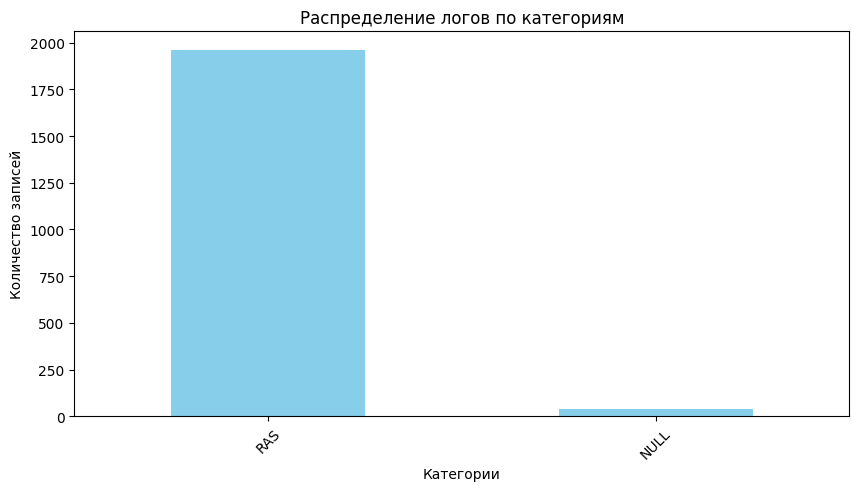

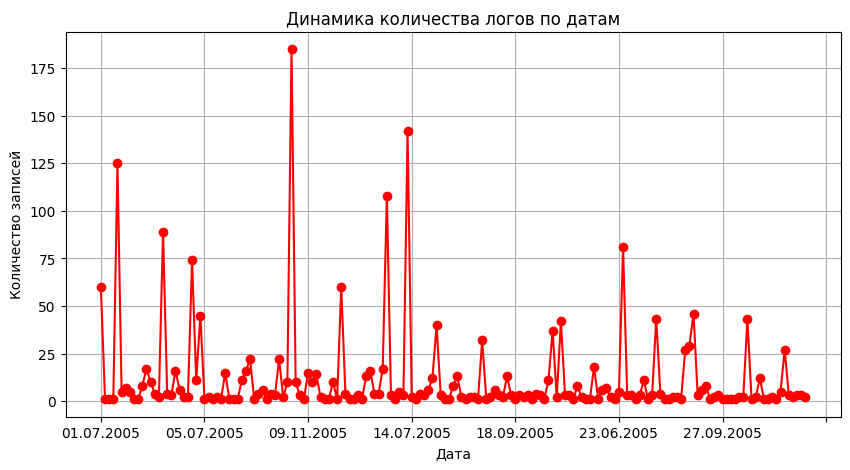

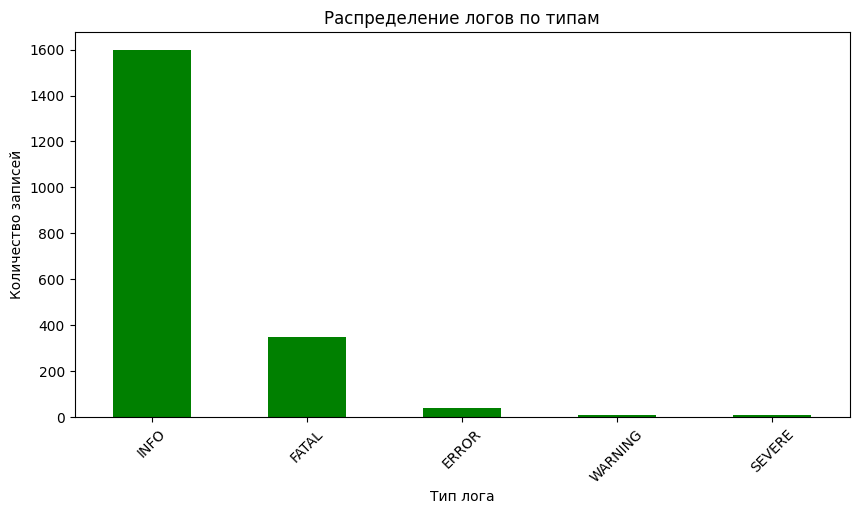

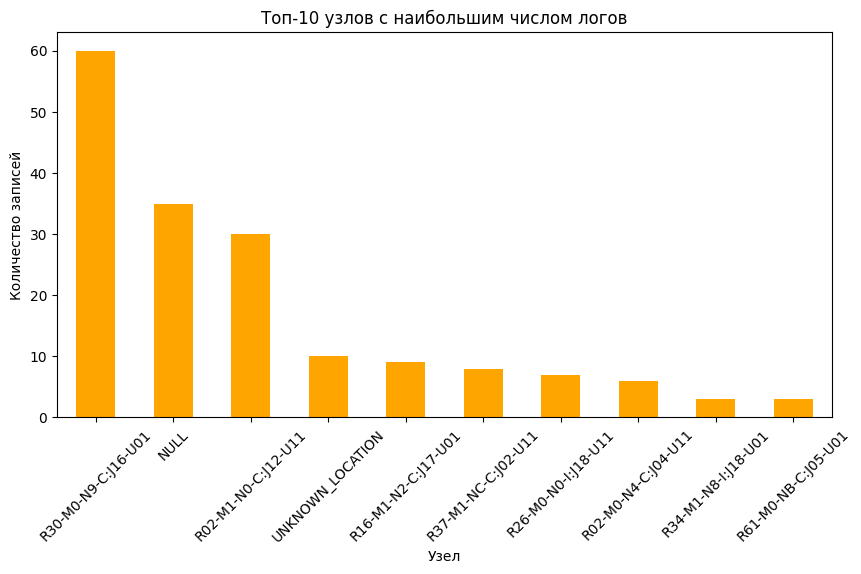

In [28]:
if log_df.empty:
    print("DataFrame пуст! Проверьте регулярное выражение и загрузку данных.")
else:
    # Визуализация количества записей по категориям
    plt.figure(figsize=(10, 5))
    log_df['Category'].value_counts().plot(kind='bar', color='skyblue')
    plt.title("Распределение логов по категориям")
    plt.xlabel("Категории")
    plt.ylabel("Количество записей")
    plt.xticks(rotation=45)
    plt.show()

    # Визуализация количества логов по дате
    plt.figure(figsize=(10, 5))
    log_df['EventDate'].value_counts().sort_index().plot(kind='line', marker='o', color='red')
    plt.title("Динамика количества логов по датам")
    plt.xlabel("Дата")
    plt.ylabel("Количество записей")
    plt.grid()
    plt.show()

    # Анализ наиболее частых типов сообщений
    plt.figure(figsize=(10, 5))
    log_df['Type'].value_counts().plot(kind='bar', color='green')
    plt.title("Распределение логов по типам")
    plt.xlabel("Тип лога")
    plt.ylabel("Количество записей")
    plt.xticks(rotation=45)
    plt.show()

    # Анализ наиболее активных узлов
    plt.figure(figsize=(10, 5))
    log_df['Node'].value_counts().head(10).plot(kind='bar', color='orange')
    plt.title("Топ-10 узлов с наибольшим числом логов")
    plt.xlabel("Узел")
    plt.ylabel("Количество записей")
    plt.xticks(rotation=45)
    plt.show()